# GANs

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
from pathlib import Path
from collections import defaultdict

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision as tv
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
H, W = 64, 64
PATH_DATA = Path(f"/data/data.sets/free/Faces/faces_dataset_{H}x{W}/")
# PATH_DATA = Path(f"/data/data.sets/free/Faces_small/faces_dataset_small_{H}x{W}/")
NUM_EPOCHS = 251
BATCH_SIZE = 128
LATENT_SIZE = 100
LR = 2e-4
CHANNEL_IMG = 3
FEATURES_G = 64
FEATURES_D = 64
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(PATH_DATA.exists())
print(DEVICE)

True
cuda:0


In [3]:
class FaceDataset(torch.utils.data.Dataset):
    """Faces Dataset"""

    def __init__(self, filenames, transform=None):
        self.transform = transform
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.filenames[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            data_dict = self.transform(image=image)
            image = data_dict["image"]
        return image

In [4]:
transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Normalize(
            mean=MEAN,
            std=STD,
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

# split to train and valid filenames
filenames = [str(fn) for fn in Path(PATH_DATA).rglob("*.png")]
percent_split = 30

train_face_ds = FaceDataset(
    filenames=filenames[:len(filenames)//100*percent_split],
    transform=transforms,
)
valid_face_ds = FaceDataset(
    filenames=filenames[len(filenames)//100*percent_split:],
    transform=transforms,
)
train_face_dl = DataLoader(
    train_face_ds,
    BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

if __name__ == "__main__":
    img = next(iter(train_face_ds))
    print(img.shape)
    print(img.dtype)
    print(img.mean(axis=(1,2)))
    print(img.std(axis=(1,2)))

torch.Size([3, 64, 64])
torch.float32
tensor([ 0.0641, -0.0914, -0.1159])
tensor([0.3300, 0.3615, 0.4294])


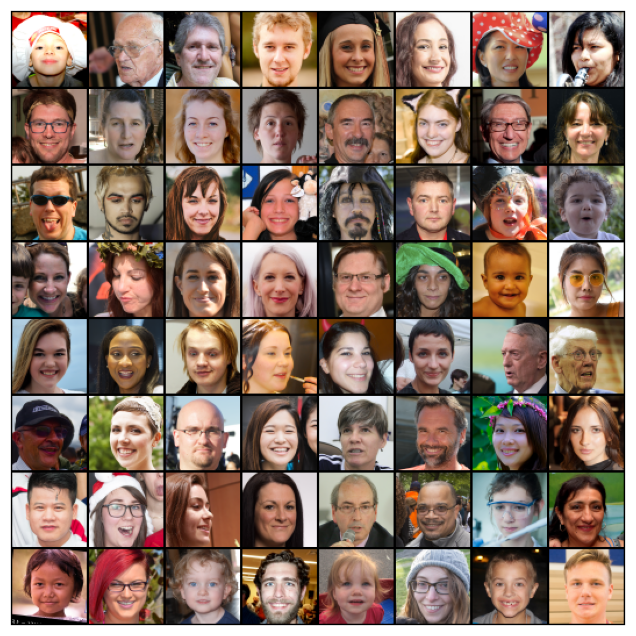

In [157]:
def denormalize_image(image):
    image = image * STD + MEAN
    return image

def denormalize_batch(batch):
    for ic in range(batch.shape[1]):
        # ic - i color
        batch[:, ic, ...] = batch[:, ic, ...] * STD[ic] + MEAN[ic]
    return batch

def show_images(images, nmax=64, denorm=True, show=True):
    imgs = images.cpu().detach()[:nmax]
    if denorm:
        imgs = denormalize_batch(imgs)
    imgs = make_grid(imgs, nrow=8)
    imgs = imgs.permute(1, 2, 0)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(imgs)
        plt.show()
    return imgs

def show_batch(batch, nmax=64, denorm=True):
    show_images(batch, nmax, denorm)


if __name__ == "__main__":
    batch = next(iter(train_face_dl))
    # print(torch.mean(batch, [0,2,3]))
    # print(torch.std(batch, [0,2,3]))
    show_images(batch, nmax=64, denorm=True)

torch.Size([128, 100, 1, 1])
torch.Size([128, 3, 64, 64])


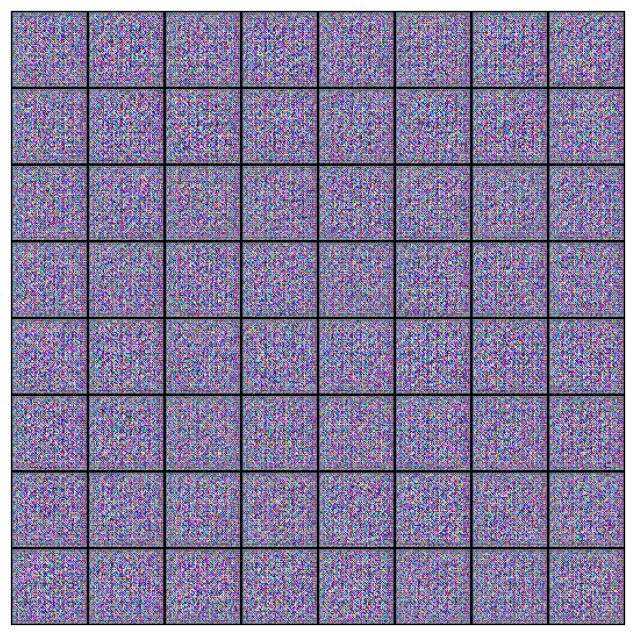

In [8]:
class NoiseDataset(torch.utils.data.Dataset):
    """Noises Dataset"""

    def __init__(self, z_dim: int, len_ds: int):
        self.z_dim = z_dim
        self.len_ds = len_ds

    def __len__(self):
        return self.len_ds

    def __getitem__(self, index):
        return torch.randn(self.z_dim, 1, 1)


train_noise_ds = NoiseDataset(z_dim=LATENT_SIZE, len_ds=len(train_face_ds))
train_noise_dl = DataLoader(
    train_noise_ds,
    BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

if __name__ == "__main__":
    latent_vector = next(iter(train_noise_dl))
    model_g = Generator(
        z_dim=LATENT_SIZE,
        channels_img=CHANNEL_IMG,
        features_g=FEATURES_G,
    )
    images = model_g(latent_vector)
    print(latent_vector.shape)
    print(images.shape)
    show_images(images, denorm=True)
    del latent_vector
    del model_g
    del images


## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [9]:
# функция инициализации из статьи по GANs
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            nn.init.zeros_(m.bias)

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(inplace=True),
            # state size. (features_g*8) x 4 x 4
            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(inplace=True),
            # state size. (features_g*4) x 8 x 8
            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(inplace=True),
            # state size. (features_g*2) x 16 x 16
            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(inplace=True),
            # state size. (features_g) x 32 x 32
            nn.ConvTranspose2d(features_g, channels_img, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (features_g) x 64 x 64
        )

    def forward(self, x):
        return self.gen(x)


def test_Generator():
    x_dumb = torch.randn((BATCH_SIZE, LATENT_SIZE, 1, 1), dtype=torch.float)
    model_g = Generator(
        z_dim=LATENT_SIZE,
        channels_img=CHANNEL_IMG,
        features_g=FEATURES_G,
    )
    initialize_weights(model_g)
    y_dumb = model_g(x_dumb)
    print(x_dumb.shape)
    print(y_dumb.shape)
    assert y_dumb.shape == (BATCH_SIZE, CHANNEL_IMG, H, W)


if __name__ == "__main__":
    test_Generator()

torch.Size([128, 100, 1, 1])
torch.Size([128, 3, 64, 64])


In [11]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(channels_img, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (features_d) x 32 x 32
            nn.Conv2d(features_d, features_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (features_d*2) x 16 x 16
            nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (features_d*4) x 8 x 8
            nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (features_d*8) x 4 x 4
            nn.Conv2d(features_d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


def test_Discriminator():
    x_dumb = torch.randn((BATCH_SIZE, CHANNEL_IMG, H, W), dtype=torch.float)
    model_d = Discriminator(
        channels_img=CHANNEL_IMG,
        features_d=FEATURES_D,
    )
    initialize_weights(model_d)
    y_dumb = model_d(x_dumb)
    print(x_dumb.shape)
    print(y_dumb.shape)
    assert y_dumb.shape == (BATCH_SIZE, 1, 1, 1)


if __name__ == "__main__":
    test_Discriminator()

torch.Size([128, 3, 64, 64])
torch.Size([128, 1, 1, 1])


Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [12]:
def save_samples(index, fake_images, name="generated", show=True):
    path = Path("./generated-fixed/")
    path.mkdir(parents=True, exist_ok=True)

    # denorm_fake_images = denormalize_batch(fake_images)
    fn = path / f"{name}-{index:04d}.png"
    imgs = show_images(fake_images, nmax=64, denorm=True, show=show)
    plt.imsave(str(fn), imgs.cpu().detach().numpy())
    print(f"Saving: {fn.name}")

In [15]:
fixed_latent = torch.randn(size=(BATCH_SIZE, LATENT_SIZE, 1, 1), device=DEVICE)

In [41]:
model_g = Generator(
    z_dim=LATENT_SIZE,
    channels_img=CHANNEL_IMG,
    features_g=FEATURES_G,
)
model_d = Discriminator(
    channels_img=CHANNEL_IMG,
    features_d=FEATURES_D,
)
model_g.apply(initialize_weights)
model_d.apply(initialize_weights)
model_g.to(DEVICE)
model_d.to(DEVICE)
model_g.train()
model_d.train()

opt_g = torch.optim.Adam(
    model_g.parameters(),
    lr=LR,
    betas=(0.5, 0.999),
)
opt_d = torch.optim.Adam(
    model_d.parameters(),
    lr=LR,
    betas=(0.5, 0.999),
)
criterion = nn.BCELoss()

global_step = 0
global_history = defaultdict(list)
for epoch in range(NUM_EPOCHS):
    history = defaultdict(list)
    for real_images, latent_vector in zip(train_face_dl, train_noise_dl):
        real_images = real_images.to(DEVICE)
        latent_vector = latent_vector.to(DEVICE)
        # latent_vector = torch.randn((BATCH_SIZE, LATENT_SIZE, 1, 1)).to(DEVICE)

        # ----- # (1) Update D: maximize log(D(x)) + log(1 - D(G(z))) -----
        real_preds = model_d(real_images)  # D(x)
        fake_preds = model_d(model_g(latent_vector).detach())  # D(G(z))

        # Update discriminator weights
        loss_d_real = criterion(real_preds, torch.ones_like(real_preds))
        loss_d_fake = criterion(fake_preds, torch.zeros_like(fake_preds))
        loss_d = loss_d_real + loss_d_fake

        loss_d.backward(retain_graph=True)
        if global_step % 1 == 0:
            opt_d.step()
            opt_d.zero_grad()

        # ----- # (2) Update G: maximize log(D(G(z))) -----
        preds = model_d(model_g(latent_vector))  # D(G(z))
        loss_g = criterion(preds, torch.ones_like(preds))

        loss_g.backward()
        if global_step % 1 == 0:
            opt_g.step()
            opt_g.zero_grad()

        # ----- Save batch history -----
        history["score_fake"].append(torch.mean(fake_preds).cpu().detach().numpy())
        history["score_real"].append(torch.mean(real_preds).cpu().detach().numpy())
        history["loss_g"].append(loss_g.cpu().detach().numpy())
        history["loss_d"].append(loss_d.cpu().detach().numpy())

        global_step += 1

    # Record losses & scores
    global_history["score_fake"].append(np.mean(history["score_fake"]))
    global_history["score_real"].append(np.mean(history["score_real"]))
    global_history["loss_g"].append(np.mean(history["loss_g"]))
    global_history["loss_d"].append(np.mean(history["loss_d"]))

    if epoch % 10 == 0:
        print(
            f"Epoch [{epoch:04d}/{NUM_EPOCHS:04d}]"
            f", loss_g: {global_history['loss_g'][-1]:.4f}"
            f", loss_d: {global_history['loss_g'][-1]:.4f}"
            f", score_real: {global_history['score_real'][-1]:.4f}"
            f", score_fake: {global_history['score_fake'][-1]:.4f}"
        )

    # Save generated images
    if (epoch % 10 == 0) or (epoch + 1 == NUM_EPOCHS):
        fake_images = model_g(latent_vector)
        fake_images_fixed = model_g(fixed_latent)
        save_samples(epoch, fake_images, "gen-randn", show=False)
        save_samples(epoch, fake_images_fixed, "gen-fixed", show=False)

    if epoch % 10 == 0:
        torch.save(model_g.state_dict(), f"./models/generator-{epoch:04d}.pth")
        torch.save(model_d.state_dict(), f"./models/discriminator-{epoch:04d}.pth")

Epoch [0000/0251], loss_g: 0.6874, loss_d: 0.6874, score_real: 0.9284, score_fake: 0.5074
Saving: gen-randn-0000.png
Saving: gen-fixed-0000.png
Epoch [0010/0251], loss_g: 0.5556, loss_d: 0.5556, score_real: 0.7957, score_fake: 0.6264
Saving: gen-randn-0010.png
Saving: gen-fixed-0010.png
Epoch [0020/0251], loss_g: 0.5618, loss_d: 0.5618, score_real: 0.8044, score_fake: 0.6202
Saving: gen-randn-0020.png
Saving: gen-fixed-0020.png
Epoch [0030/0251], loss_g: 0.5801, loss_d: 0.5801, score_real: 0.8240, score_fake: 0.6097
Saving: gen-randn-0030.png
Saving: gen-fixed-0030.png
Epoch [0040/0251], loss_g: 0.6011, loss_d: 0.6011, score_real: 0.8460, score_fake: 0.5978
Saving: gen-randn-0040.png
Saving: gen-fixed-0040.png
Epoch [0050/0251], loss_g: 0.6089, loss_d: 0.6089, score_real: 0.8539, score_fake: 0.5948
Saving: gen-randn-0050.png
Saving: gen-fixed-0050.png
Epoch [0060/0251], loss_g: 0.6085, loss_d: 0.6085, score_real: 0.8547, score_fake: 0.5935
Saving: gen-randn-0060.png
Saving: gen-fixed-0

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(global_history['loss_d'], '-')
plt.plot(global_history['loss_g'], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Пытаются найти равновесие. Но вместо предложенного датасета (~3000 изображений) использовался увеличенный датасет из исходного набора данных (21000 изображений).

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [159]:
# Загрузим веса из чекпоинта
model_g = Generator(
    z_dim=LATENT_SIZE,
    channels_img=CHANNEL_IMG,
    features_g=FEATURES_G,
).to(DEVICE)
state_dict = torch.load("./models/generator-0250.pth")
model_g.load_state_dict(state_dict)
model_g.train(False)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

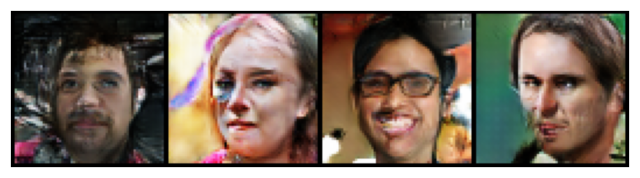

In [160]:
with torch.inference_mode():
    imgs = show_images(model_g(fixed_latent), nmax=4, denorm=True, show=True)

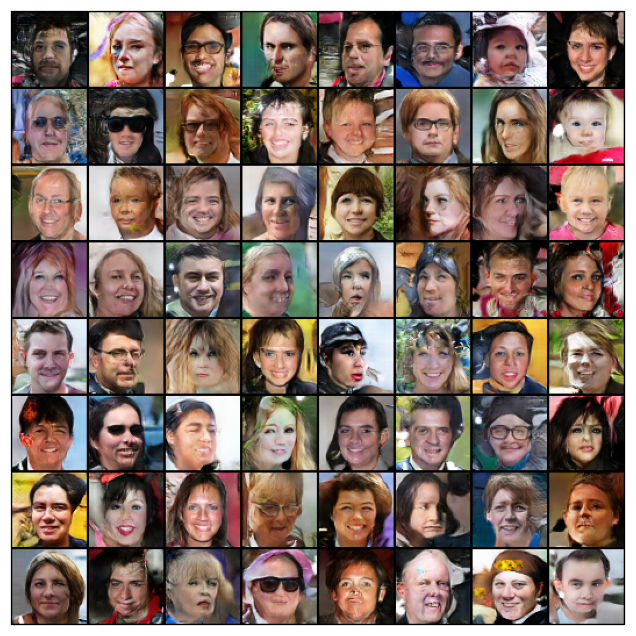

In [161]:
with torch.inference_mode():
    imgs = show_images(model_g(fixed_latent), nmax=64, denorm=True, show=True)

Как вам качество получившихся изображений?

Оно конечно работает, но достаточно крипово :)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [25]:
# сохраненная модель
model_g = Generator(
    z_dim=LATENT_SIZE,
    channels_img=CHANNEL_IMG,
    features_g=FEATURES_G,
).to(DEVICE)
state_dict = torch.load("./models/generator-0250.pth")
model_g.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
# сохраним 1000 изображений
model_g.train(False)
with torch.inference_mode():
    for i in range(1000):
        latent = torch.randn(size=(1, LATENT_SIZE, 1, 1), device=DEVICE)
        output = model_g(latent)
        fake_image = output.squeeze(0).permute(1, 2, 0)
        fake_image = fake_image.cpu().detach().numpy()
        fake_image = denormalize_image(fake_image)
        fn = Path(f"./generated-noise/{i:05d}.png")
        plt.imsave(fn, fake_image)

In [89]:
transforms = A.Compose(
    [
        A.Normalize(
            mean=MEAN,
            std=STD,
            max_pixel_value=255.0,
        ),
    ]
)
fns_real = [str(fn) for fn in Path(PATH_DATA).rglob("*.png")][-1000:]
fns_fake = [str(fn) for fn in Path("./generated-noise/").rglob("*.png")]
fns = fns_real + fns_fake
Y = np.concatenate((np.ones(1000), np.zeros(1000)))
print(f"Total images (real+fake): {len(fns)}")

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

loo = LeaveOneOut()
loo.get_n_splits(fns)

predictions = []
right_or_not = []
for i, (train_index, valid_index) in enumerate(loo.split(fns)):
    train_dataset = FaceDataset(
        filenames=[fns[index] for index in train_index],
        transform=transforms,
    )
    valid_dataset = FaceDataset(
        filenames=[fns[index] for index in valid_index],
        transform=transforms,
    )
    train_x = [img.flatten() for img in train_dataset]
    valid_x = [img.flatten() for img in valid_dataset]
    train_y = [Y[index] for index in train_index]
    valid_y = [Y[index] for index in valid_index]
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(train_x, train_y)
    pred = neigh.predict(valid_x)
    predictions.append(pred)
    right_or_not.append(pred == valid_y)

accuracy = sum(right_or_not) / len(fns)
print(accuracy)

Total images, real+fake: 2000
[0.6015]


In [142]:
accuracy = sum(right_or_not) / len(fns)
print(f"Accuracy after LOO for 1000_real + 1000_fake images: {accuracy}")

Accuracy after LOO for 1000_real + 1000_fake images: [0.6015]


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Хотелось бы получить accuracy равный 0.5, это означало бы, что дискриминатор не может отличить настоящую картинку от сгенерированной.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [123]:
from sklearn.manifold import TSNE

train_dataset = FaceDataset(
    filenames=fns_real,
    transform=transforms,
)
valid_dataset = FaceDataset(
    filenames=fns_fake,
    transform=transforms,
)
images_all = np.concatenate((train_dataset, valid_dataset), axis=0)
Z = images_all.reshape(images.shape[0], -1)

z_low = torch.from_numpy(TSNE(n_components=2).fit_transform(Z))

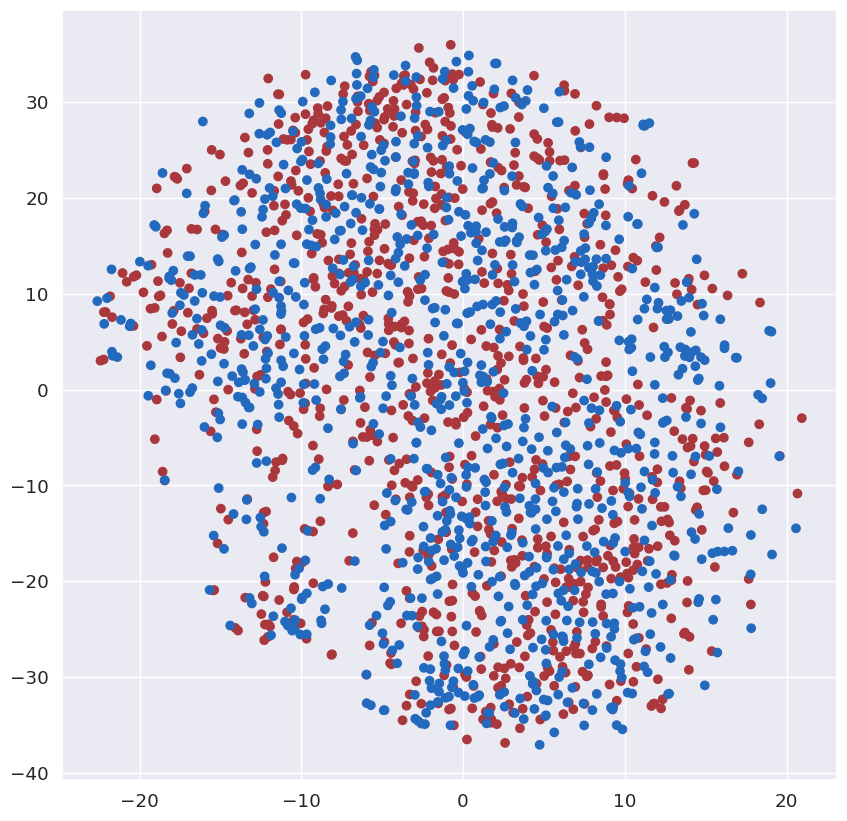

In [156]:
plt.figure(figsize=(10, 10))
plt.grid('on')
plt.scatter(z_low[:, 0], z_low[:, 1], c=Y, cmap='vlag')
plt.show()

Прокомментируйте получившийся результат:

Распределения в целом похожи, однако есть некоторые скопления точек одного цвета, что говорит о наличии значительных отличий между настоящими и сгенерированными картинками.